# BANA-273 Term Project
### Group 22: William Leonard, Susan Mikhail, Matthias Ronnau, Lokesh Nandni Sood, Parsa Tahmasebi

## Import Packages and Read in the Data

In [463]:
#Import packages
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import statsmodels.api as sm
import sklearn
from sklearn import linear_model
#from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [158]:
#Read in the data
vehicles = pd.read_csv("vehicles.csv")

In [376]:
#Take a look at the data
cars = vehicles.copy()
cars.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7184791621,https://duluth.craigslist.org/ctd/d/duluth-200...,duluth / superior,https://duluth.craigslist.org,6995,2000.00000,gmc,new sierra 1500,excellent,8 cylinders,...,4wd,NaN,NaN,red,https://images.craigslist.org/00n0n_f06ykBMcdh...,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,nan,mn,46.84330,-92.25500
1,7184773187,https://duluth.craigslist.org/cto/d/saginaw-20...,duluth / superior,https://duluth.craigslist.org,8750,2013.00000,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,NaN,grey,https://images.craigslist.org/00d0d_kgZ6xoeRw2...,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,nan,mn,46.90740,-92.46380
2,7193375964,https://newhaven.craigslist.org/cto/d/stratfor...,new haven,https://newhaven.craigslist.org,10900,2013.00000,toyota,prius,good,4 cylinders,...,fwd,NaN,NaN,blue,https://images.craigslist.org/00d0d_3sHGxPbY2O...,2013 Prius V Model Two. One owner—must sell my...,nan,ct,41.17700,-73.13360
3,7195108810,https://albuquerque.craigslist.org/cto/d/albuq...,albuquerque,https://albuquerque.craigslist.org,12500,2003.00000,mitsubishi,lancer,good,4 cylinders,...,4wd,mid-size,sedan,grey,https://images.craigslist.org/00m0m_4a8Pb6JbMG...,"2003 Mitsubishi Lancer Evolution, silver. Abo...",nan,nm,35.18680,-106.66500
4,7184712241,https://duluth.craigslist.org/ctd/d/rush-city-...,duluth / superior,https://duluth.craigslist.org,16995,2007.00000,gmc,sierra classic 2500hd,good,8 cylinders,...,4wd,full-size,truck,white,https://images.craigslist.org/01414_g093aPtSMW...,"**Bad Credit, No Credit... No Problem!**2007 G...",nan,mn,45.68360,-92.96480


## Exploratory Data Analysis and Data Cleaning

In [377]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423857 entries, 0 to 423856
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            423857 non-null  int64  
 1   url           423857 non-null  object 
 2   region        423857 non-null  object 
 3   region_url    423857 non-null  object 
 4   price         423857 non-null  int64  
 5   year          328743 non-null  float64
 6   manufacturer  313242 non-null  object 
 7   model         325384 non-null  object 
 8   condition     176719 non-null  object 
 9   cylinders     197679 non-null  object 
 10  fuel          327214 non-null  object 
 11  odometer      270585 non-null  float64
 12  title_status  327759 non-null  object 
 13  transmission  328065 non-null  object 
 14  vin           184420 non-null  object 
 15  drive         231119 non-null  object 
 16  size          102627 non-null  object 
 17  type          241157 non-null  object 
 18  pain

In [378]:
cars.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

In [379]:
#Remove columns unnescessary for the analysis
cars.drop(["id", "url", "region", "region_url", "model", "vin", "image_url", "county", "lat", "long"], axis = 1, inplace = True)
cars.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state
0,6995,2000.00000,gmc,excellent,8 cylinders,gas,167783.00000,clean,automatic,4wd,NaN,NaN,red,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,mn
1,8750,2013.00000,hyundai,excellent,4 cylinders,gas,90821.00000,clean,automatic,fwd,NaN,NaN,grey,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,mn
2,10900,2013.00000,toyota,good,4 cylinders,hybrid,92800.00000,clean,automatic,fwd,NaN,NaN,blue,2013 Prius V Model Two. One owner—must sell my...,ct
3,12500,2003.00000,mitsubishi,good,4 cylinders,gas,nan,clean,manual,4wd,mid-size,sedan,grey,"2003 Mitsubishi Lancer Evolution, silver. Abo...",nm
4,16995,2007.00000,gmc,good,8 cylinders,diesel,254217.00000,clean,automatic,4wd,full-size,truck,white,"**Bad Credit, No Credit... No Problem!**2007 G...",mn


In [380]:
#Look at the number and percent of missing values for each column
missing = pd.DataFrame(cars.isna().sum())
missing.columns = ["num_missing"]
missing["percent_missing"] = missing.num_missing / len(cars.index)
missing

,num_missing,percent_missing
price,0,0.00000
year,95114,0.22440
manufacturer,110615,0.26097
condition,247138,0.58307
cylinders,226178,0.53362
fuel,96643,0.22801
odometer,153272,0.36161
title_status,96098,0.22672
transmission,95792,0.22600
drive,192738,0.45472


In [381]:
cars.drop("size", axis = 1, inplace = True)

In [382]:
cars.columns

Index(['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'description', 'state'],
      dtype='object')

In [383]:
missing_by_manufacturer = cars[cars.columns.difference(["manufacturer"])].isnull().groupby(cars["manufacturer"]).sum().astype(int)

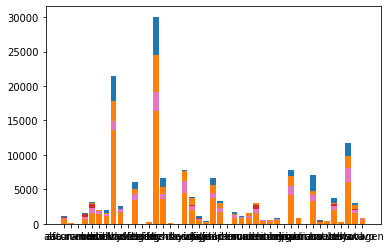

In [384]:
for i in range(len(missing_by_manufacturer.columns)):
    column = missing_by_manufacturer.iloc[:, i]
    plt.bar(list(missing_by_manufacturer.index), column)

In [385]:
missing_by_manufacturer.index

Index(['acura', 'alfa-romeo', 'aston-martin', 'audi', 'bmw', 'buick',
       'cadillac', 'chevrolet', 'chrysler', 'datsun', 'dodge', 'ferrari',
       'fiat', 'ford', 'gmc', 'harley-davidson', 'hennessey', 'honda',
       'hyundai', 'infiniti', 'jaguar', 'jeep', 'kia', 'land rover', 'lexus',
       'lincoln', 'mazda', 'mercedes-benz', 'mercury', 'mini', 'mitsubishi',
       'morgan', 'nissan', 'pontiac', 'porche', 'ram', 'rover', 'saturn',
       'subaru', 'tesla', 'toyota', 'volkswagen', 'volvo'],
      dtype='object', name='manufacturer')

In [386]:
#Restructure the column "cylinders" by only keeping the number of cylinders and removing any text from the column
cars["cylinders"].unique()
cars["cylinders"] = cars["cylinders"].fillna("")
cars["cylinders"] = pd.Series([int(x) if x.isdigit() else np.nan for x in [re.sub("[^0-9]", "", y) 
                                                                           for y in list(cars["cylinders"])]])

In [387]:
#Get descriptive statistics for the price, year of manufacture, number of cylinders, and mileage of each car
cars.describe()

,price,year,cylinders,odometer
count,423857.00000,328743.00000,196828.00000,270585.00000
mean,57794.37478,2009.82736,5.85220,99425.78461
std,10025805.11645,10.13581,1.61935,120483.31239
min,0.00000,1900.00000,3.00000,0.00000
25%,4499.00000,2007.00000,4.00000,44324.00000
50%,9995.00000,2012.00000,6.00000,91749.00000
75%,18995.00000,2016.00000,8.00000,137237.00000
max,3808256046.00000,2021.00000,12.00000,10000000.00000


In [388]:
#The max price seems very odd, let's take a look
cars.loc[cars["price"] == 3808256046.00000]

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description,state
300026,3808256046,2007.00000,saturn,good,nan,gas,nan,clean,automatic,NaN,NaN,red,"2007 Saturn Aura has 140,224 miles on it. Grea...",mi


In [389]:
list(cars.loc[cars["price"] == 3808256046.00000]["description"])

['2007 Saturn Aura has 140,224 miles on it. Great running car no check engine light on. ac and heat both work. Radio works power windows and locks. Has a sunroof works as well. Have two set of keys with automatic start. Asking for 3,000 willing to go down in price.  show contact info']

The description says that the seller is asking for $3000, so we can impute that value for the price.

In [390]:
#Impute 3000 for the price, overwriting the eroneous value that was present.
cars.iloc[300026, 0] = 3000

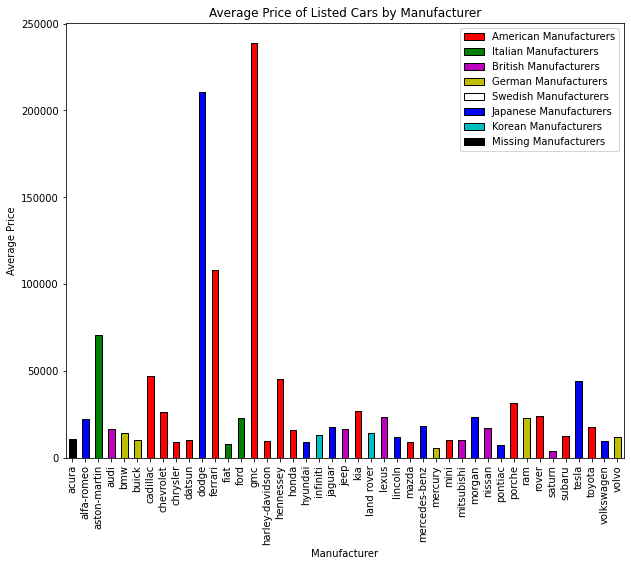

In [391]:
plt.figure(figsize = (10, 8))
cars.groupby("manufacturer").price.mean().plot.bar(color = colors, edgecolor = "k")
plt.ylabel("Average Price")
plt.xlabel("Manufacturer")
american = mpatches.Patch(facecolor = "r", edgecolor = "k", label = "American Manufacturers")
italian = mpatches.Patch(facecolor = "g", edgecolor = "k", label = "Italian Manufacturers")
british = mpatches.Patch(facecolor = "m", edgecolor = "k", label = "British Manufacturers")
german = mpatches.Patch(facecolor = "y", edgecolor = "k", label = "German Manufacturers")
swedish = mpatches.Patch(facecolor = "w", edgecolor = "k", label = "Swedish Manufacturers")
japanese = mpatches.Patch(facecolor = "b", edgecolor = "k", label = "Japanese Manufacturers")
korean = mpatches.Patch(facecolor = "c", edgecolor = "k", label = "Korean Manufacturers")
missing = mpatches.Patch(facecolor = "k", edgecolor = "k", label = "Missing Manufacturers")
plt.title("Average Price of Listed Cars by Manufacturer")
plt.legend(handles = [american, italian, british, german, swedish, japanese, korean, missing])

Dodge and GMC, which are not known to be "high end" vehicles, show a mean price that is larger than luxury brands like Aston-Martin and Ferrari. This seems od, so let's investigate.

In [393]:
cars.loc[cars["manufacturer"] == "dodge"]["price"].describe()

count        12547.00000
mean        210606.10489
std       22234124.01268
min              0.00000
25%           3481.50000
50%           8495.00000
75%          17995.00000
max     2490531375.00000
Name: price, dtype: float64

In [394]:
cars.loc[cars["price"] == 2490531375.00000]

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description,state
67033,2490531375,2014.00000,dodge,good,4.00000,gas,112589.00000,clean,automatic,fwd,sedan,red,"J.P. AUTO ENTERPRISE 3558 BUFORD HWY, SUITE B-...",ga


In [395]:
list(cars.loc[cars["price"] == 2490531375.00000]["description"])

['J.P. AUTO ENTERPRISE 3558 BUFORD HWY, SUITE B-100 DULUTH, GA 30096 CEL: 678-549-8671 www.jpcarsandbikes.com  Information VIN: 1C3CDFBB6ED695611 Make: Dodge Model: Dart  Model Year: 2014 Trim Package: SXT 4 Door Sedan  Body Style: Sedan  Engine: 2.4L I4 Fuel Type: Gasoline Drivetrain: FWD']

Seeing that there is no info regarding the price in the description, we should remove this data point as it is likely an error.

In [396]:
cars.drop(index = 67033, inplace = True)

In [397]:
cars.loc[cars["manufacturer"] == "gmc"]["price"].describe()

count        12782.00000
mean        238584.92974
std       24839841.83032
min              0.00000
25%           6850.00000
50%          14000.00000
75%          27990.00000
max     2808348671.00000
Name: price, dtype: float64

In [398]:
cars.loc[cars["price"] == 2808348671.00000]

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description,state
207260,2808348671,2020.00000,gmc,NaN,8.00000,gas,nan,clean,automatic,NaN,NaN,NaN,"WILL BUY YOU RLIFTED OR LOWERED TRUCK , SINGLE...",ca


In [399]:
list(cars.loc[cars["price"] == 2808348671.00000]["description"])

['WILL BUY YOU RLIFTED OR LOWERED TRUCK , SINGLE CABS SHORT BED , JEEPS LIFTED OR CUSTOM     WILL PAY CASH  PLEASE CALL US     (209)544-1388']

Seeing that there is no info regarding the price in the description, we should remove this data point as it is likely an error.

In [400]:
cars.drop(index = 207260, inplace = True)

In [401]:
#After removing the two erroneous rows, reset the index
cars.reset_index(inplace = True, drop = True)

In [402]:
#As seen above, the max value for the column "odometer" was 10000000.00. This seems unrealistic. Let's take a look.

cars.loc[cars["odometer"] == 10000000.00000]

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description,state
95591,38900,1990.00000,NaN,good,8.00000,diesel,10000000.00000,clean,manual,rwd,truck,grey,"This is a 1990 Peterbilt 379 long hood, has a ...",nj
197082,1400,2000.00000,chevrolet,good,8.00000,gas,10000000.00000,clean,automatic,4wd,truck,black,"Good work truck , 4x4 works , AC works PW wido...",oh
262694,3800,1936.00000,chevrolet,fair,6.00000,gas,10000000.00000,rebuilt,manual,rwd,sedan,black,"Four door 1936 chevy car, All parts are there....",sd
311728,6200,1915.00000,NaN,good,4.00000,gas,10000000.00000,missing,manual,rwd,truck,black,"Estate sale find, mostly restores 1915 Maxwell...",ia


Let's replace all unrealistic values for the column "odometer" (anything above 999999, the max reading on the odometer) with an estimate of what the mileage for a car of their age should be. According to [caranddriver.com](https://www.caranddriver.com/research/a32880477/average-mileage-per-year/), the average person drive 13,500 miles per year. We can find the age of each car that lists an unrealistic value, multiply this by 13,500, and impute that for the entry in odometer. If this value exceeds 999,999, we will impute 999,999 as the entry.

In [403]:
max_odometer_before_imputation = cars["odometer"].max()

In [404]:
cars["odometer"] = [x if x <= 999999 else min(999999, (13500 * (2021 - cars["year"][i]))) for i, x in enumerate(cars["odometer"])]

In [405]:
max_odometer_after_imputation = cars["odometer"].max()

In [406]:
print(max_odometer_before_imputation)
print(max_odometer_after_imputation)

10000000.0
999999.0


In [407]:
cars["manufacturer"].fillna("MISSING", inplace = True)

In [408]:
manufacturers = sorted(list(cars["manufacturer"].unique()))
nationalities = ["MISSING", "Japanese", "Italian", "British", "German", "German", "American", "American", "American", 
                 "American", "Japanese", "American", "Italian", "Italian", "American", "American", "American", "American", 
                "Japanese", "Korean", "Japanese", "British", "American", "Korean", "British", "Japanese", "American", 
                 "Japanese", "German", "American", "British", "Japanese", "British", "Japanese", "American", "German", 
                 "American", "British", "American", "Japanese", "American", "Japanese", "German", "Swedish"]

manufacturers_dictionary = {}
for i in range(len(manufacturers)):
    manufacturers_dictionary[manufacturers[i]] = nationalities[i]

In [409]:
cars["manufacturer_nationality"] = cars["manufacturer"].map(manufacturers_dictionary)

In [410]:
cars.groupby("manufacturer_nationality")["manufacturer_nationality"].count()

manufacturer_nationality
American    180797
British       3304
German       25037
Italian        769
Japanese     85402
Korean       15834
MISSING     110615
Swedish       2097
Name: manufacturer_nationality, dtype: int64

In [411]:
manufacturer_nationalities = sorted(list(cars["manufacturer_nationality"].unique()))
nationality_colors = ["r", "m", "y", "g", "b", "c", "k", "w"]

manufacturers_colors = {}
for i in range(len(manufacturer_nationalities)):
    manufacturers_colors[manufacturer_nationalities[i]] = nationality_colors[i]

In [412]:
manufacturers_colors

{'American': 'r',
 'British': 'm',
 'German': 'y',
 'Italian': 'g',
 'Japanese': 'b',
 'Korean': 'c',
 'MISSING': 'k',
 'Swedish': 'w'}

In [413]:
cars["nationality_colors"] = cars["manufacturer_nationality"].map(manufacturers_colors)

Text(0.5, 1.0, 'Mean List Price by Car Manufacturer')

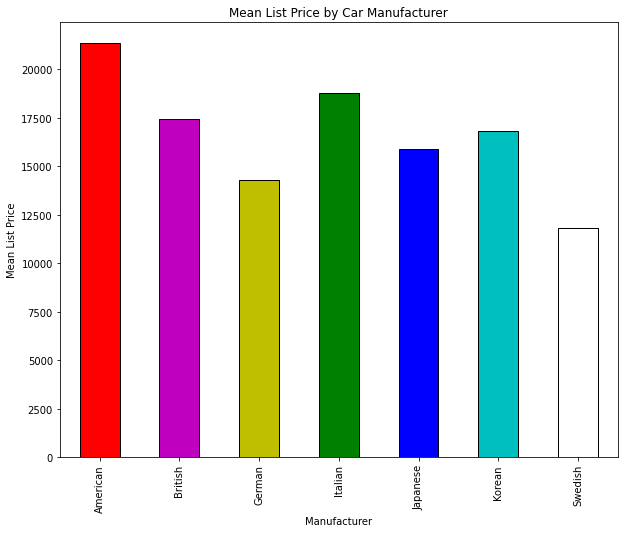

In [416]:
#Visualize the Mean List Price of 
plt.figure(figsize = (10, 8))
cars.loc[cars["manufacturer_nationality"] != "MISSING"].groupby(
    "manufacturer_nationality")["price"].mean().plot.bar(color = ["r", "m", "y", "g", "b", "c", "w"], edgecolor = "k")
plt.xlabel("Manufacturer")
plt.ylabel("Mean List Price")
plt.title("Mean List Price by Car Manufacturer")

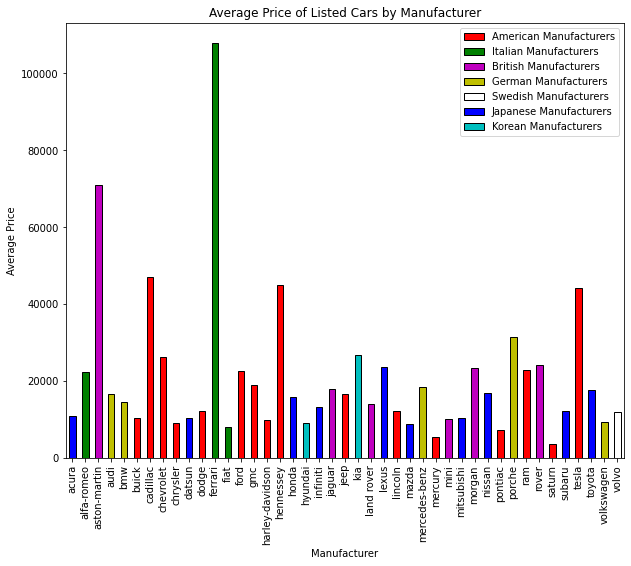

In [419]:
colors = ["b", "g", "m", "y", "y", "r", "r", "r", "r", "b", "r", "g", "g", "r", "r", "r", "r", "b", "c", "b", "m", 
         "r", "c", "m", "b", "r", "b", "y", "r", "m", "b", "m", "b", "r", "y", "r", "m", "r", "b", "r", "b", "y", "w"]

plt.figure(figsize = (10, 8))
cars.loc[cars["manufacturer_nationality"] != "MISSING"].groupby("manufacturer").price.mean().plot.bar(color = 
                                                                                                      colors, edgecolor = "k")
plt.ylabel("Average Price")
plt.xlabel("Manufacturer")
american = mpatches.Patch(facecolor = "r", edgecolor = "k", label = "American Manufacturers")
italian = mpatches.Patch(facecolor = "g", edgecolor = "k", label = "Italian Manufacturers")
british = mpatches.Patch(facecolor = "m", edgecolor = "k", label = "British Manufacturers")
german = mpatches.Patch(facecolor = "y", edgecolor = "k", label = "German Manufacturers")
swedish = mpatches.Patch(facecolor = "w", edgecolor = "k", label = "Swedish Manufacturers")
japanese = mpatches.Patch(facecolor = "b", edgecolor = "k", label = "Japanese Manufacturers")
korean = mpatches.Patch(facecolor = "c", edgecolor = "k", label = "Korean Manufacturers")]
plt.title("Average Price of Listed Cars by Manufacturer")
plt.legend(handles = [american, italian, british, german, swedish, japanese, korean])

In [335]:
cars["price"].describe()

count       423855.00000
mean         36308.21205
std        5749884.40163
min              0.00000
25%           4499.00000
50%           9995.00000
75%          18995.00000
max     2632269824.00000
Name: price, dtype: float64

In [336]:
cars.drop(index = cars.loc[cars["price"] > 300000].index, inplace = True)

cars.drop(index = cars.loc[cars["price"] < 100].index, inplace = True)

cars.reset_index(inplace = True, drop = True)

In [337]:
cars["price"].describe()

count   386131.00000
mean     15221.11954
std      14036.89218
min        100.00000
25%       5900.00000
50%      11500.00000
75%      19995.00000
max     300000.00000
Name: price, dtype: float64

In [338]:
min_price = cars["price"].min()
price_25 = cars["price"].quantile(0.25)
price_50 = cars["price"].quantile(0.50)
price_75 = cars["price"].quantile(0.75)
max_price = cars["price"].max()

price_binned = pd.cut(cars["price"], bins = [min_price, price_25, price_50, price_75, max_price], 
       labels = ["Very Low", "Low", "Mid-High", "Expensive"])

In [339]:
cars["price_binned"] = price_binned
cars = cars[[cars.columns[0]] + [cars.columns[-1]] + list(cars.columns[1:-1])]

In [340]:
cars_no_missing = cars.copy()
cars_no_missing = cars_no_missing[cars_no_missing["manufacturer"] != "MISSING"]
cars_no_missing.dropna(inplace = True, axis = 0)
cars_no_missing.reset_index(inplace = True, drop = True)

In [341]:
cars_no_missing.columns

Index(['price', 'price_binned', 'year', 'manufacturer', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'type', 'paint_color', 'description', 'state',
       'manufacturer_nationality', 'nationality_colors'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

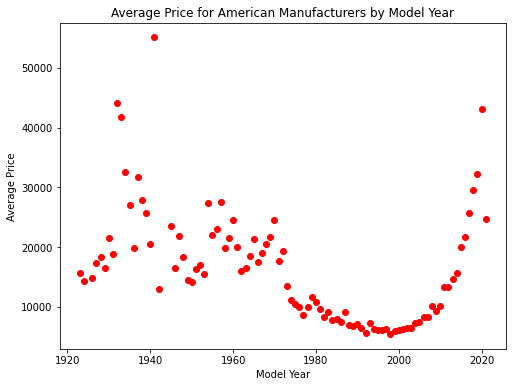

<Figure size 432x288 with 0 Axes>

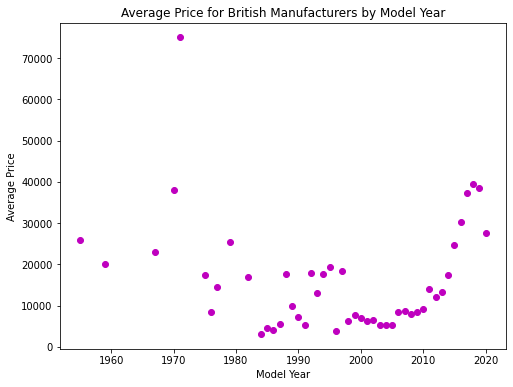

<Figure size 432x288 with 0 Axes>

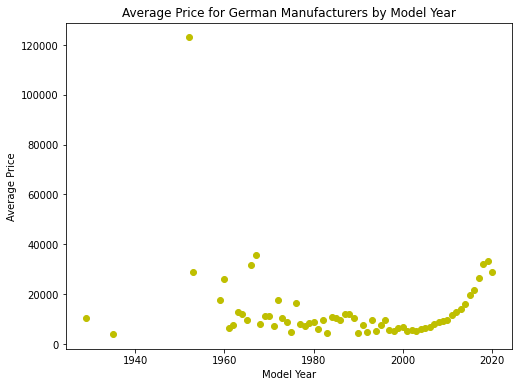

<Figure size 432x288 with 0 Axes>

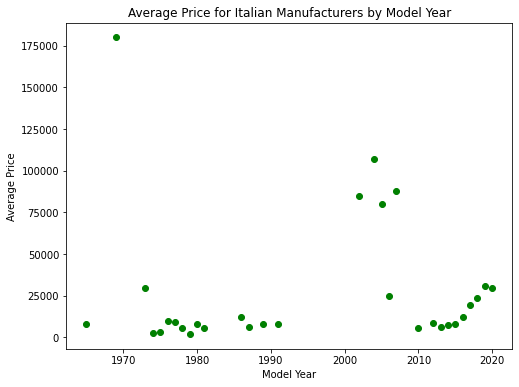

<Figure size 432x288 with 0 Axes>

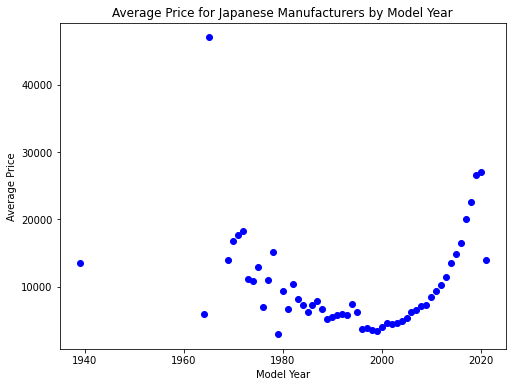

<Figure size 432x288 with 0 Axes>

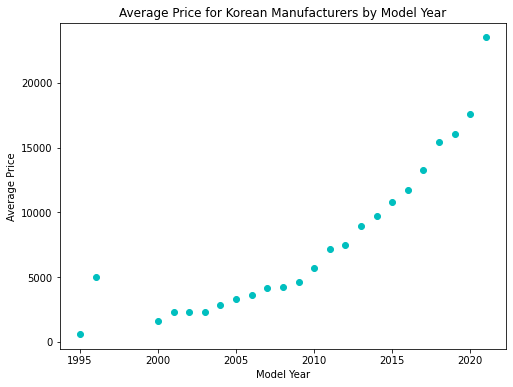

<Figure size 432x288 with 0 Axes>

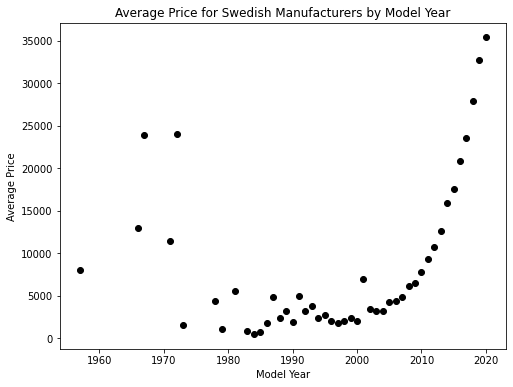

In [449]:
#Generate plots for each manufacturer denoting the mean price of cars listed for that year and plot it
no_missing_manufacturer_nationalities = sorted(list(cars_no_missing["manufacturer_nationality"].unique()))
no_missing_manufacturer_nationalities_colors = ["r", "m", "y", "g", "b", "c", "k"]

for i in range(len(no_missing_manufacturer_nationalities)):
    manufacturer_nationality = no_missing_manufacturer_nationalities[i]
    x = sorted(cars_no_missing[cars_no_missing["manufacturer_nationality"] ==  manufacturer_nationality]["year"].unique())
    y = cars_no_missing[cars_no_missing["manufacturer_nationality"] ==  manufacturer_nationality].groupby("year")["price"].mean()
    plt.figure()
    plt.figure(figsize = (8, 6))
    plt.scatter(x, y, color = no_missing_manufacturer_nationalities_colors[i])
    plt.xlabel("Model Year")
    plt.ylabel("Average Price")
    plt.title("Average Price for %s Manufacturers by Model Year" %manufacturer_nationality)
plt.show()

Text(0.5, 1.0, 'Average Price in Each Price Category')

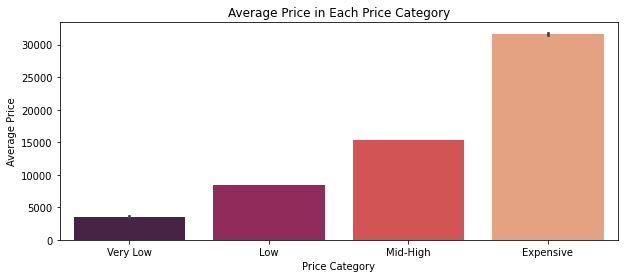

In [477]:
plt.figure(figsize = (10, 4))
sns.barplot(x = "price_binned", y = "price", data = cars_no_missing, palette = "rocket")
plt.xlabel("Price Category")
plt.ylabel("Average Price")
plt.title("Average Price in Each Price Category")

Text(0.5, 1.0, 'Number of Listings per Price Category')

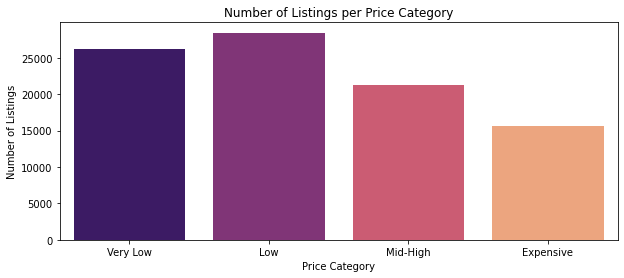

In [484]:
plt.figure(figsize = (10, 4))
sns.countplot(x = "price_binned", data = cars_no_missing, palette = "magma")
plt.xlabel("Price Category")
plt.ylabel("Number of Listings")
plt.title("Number of Listings per Price Category")

In [451]:
numerical = cars_no_missing.loc[:, ["price", "year", "cylinders", "odometer"]]
categorical = cars_no_missing.loc[:, ["manufacturer", "condition", "fuel", "title_status", "transmission", "drive", 
                           "type", "paint_color", "state"]]
binned_prediction = cars_no_missing["price_binned"]

In [444]:
#Create k-1 dummy variables for each k-level categorical variable
categorical_dummies = pd.get_dummies(categorical.iloc[:, 0:9], drop_first = True)

In [445]:
cars_linear_data = pd.concat([numerical, categorical_dummies], axis = 1)
cars_linear_data.head()

,price,year,cylinders,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
0,12500,2003.00000,4.00000,243000.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16995,2007.00000,8.00000,254217.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13995,2012.00000,6.00000,188406.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7995,2010.00000,4.00000,108124.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8995,2011.00000,6.00000,178054.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [446]:
cars_linear_data["price"].describe()

count    91546.00000
mean     12592.86646
std      10954.63778
min        123.00000
25%       5295.00000
50%       9295.00000
75%      16488.00000
max     265000.00000
Name: price, dtype: float64

In [447]:
cars_price_binned = cars_linear_data.copy()
cars_price_binned["price_binned"] = binned_prediction
cars_price_binned.drop("price", axis = 1, inplace = True)
cars_price_binned = cars_price_binned[[cars_price_binned.columns[-1]] + list(cars_price_binned.columns[0:-1])]
cars_price_binned.head()

,price_binned,year,cylinders,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
0,Mid-High,2003.00000,4.00000,243000.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Mid-High,2007.00000,8.00000,254217.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mid-High,2012.00000,6.00000,188406.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Low,2010.00000,4.00000,108124.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Low,2011.00000,6.00000,178054.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model Building

### Linear Regression

In [448]:
X_linear = cars_linear_data.iloc[:, 1:]
y_linear = cars_linear_data["price"]

X_with_constant = sm.add_constant(X_linear)
est = sm.OLS(y_linear, X_with_constant)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     449.0
Date:                Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:22:50   Log-Likelihood:            -9.5813e+05
No. Observations:               91546   AIC:                         1.917e+06
Df Residuals:                   91410   BIC:                         1.918e+06
Df Model:                         135                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [350]:
X = cars_price_binned.iloc[:, 1:]
y = cars_price_binned.iloc[:, 0]

In [351]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 212)

### Naive Bayes

In [352]:
#Bernoulli Naive Bayes
BNB = BernoulliNB()

BNB.fit(X_train, y_train)
print(BNB)

y_pred = BNB.predict(X_test)
print(accuracy_score(y_test, y_pred))

BernoulliNB()
0.4499023534474198


In [353]:
cross_val_score(BNB, X, y, cv = 10).mean()

0.4489874228072904

### Random Forest

In [354]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [355]:
model.score(X_test, y_test)

0.8008672337890173

In [356]:
cross_val_score(RandomForestClassifier(), X, y, cv = 10).mean()

0.8016517047278995

## Feature Selection

In [357]:
mutual_info = mutual_info_classif
info = mutual_info(X_train, y_train)
info_dict = dict(list(enumerate(info)))
values = sorted(info_dict.values(), reverse = True)

In [358]:
info_gain = pd.DataFrame(info_dict, index = [0]).transpose()
info_gain.columns = ["info_gain"]
info_gain["variable"] = list(X.columns)
info_gain = info_gain.iloc[:, [-1,0]].sort_values(by = "info_gain", ascending = False)
info_gain.head(10)

,variable,info_gain
2,odometer,0.36410
0,year,0.28130
60,drive_fwd,0.06167
1,cylinders,0.04496
44,condition_fair,0.04108
70,type_sedan,0.03500
59,transmission_other,0.02267
71,type_truck,0.02149
50,fuel_gas,0.01889
45,condition_good,0.01479


There are 12 variables which have an information gain over 0.01. Let's reduce the number of variables and only use those to test our models.

In [359]:
top_12 = list(info_gain[0:12].index)

In [360]:
X_cut = cars_price_binned.iloc[:, 1:].iloc[:, top_12]
y = cars_price_binned.iloc[:, 0]

In [361]:
X_cut

,odometer,year,drive_fwd,cylinders,condition_fair,type_sedan,transmission_other,type_truck,fuel_gas,condition_good,paint_color_white,type_pickup
0,243000.00000,2003.00000,0,4.00000,0,1,0,0,1,1,0,0
1,254217.00000,2007.00000,0,8.00000,0,0,0,1,0,1,1,0
2,188406.00000,2012.00000,0,6.00000,0,0,0,1,1,1,0,0
3,108124.00000,2010.00000,0,4.00000,0,0,0,0,1,1,0,0
4,178054.00000,2011.00000,0,6.00000,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
91541,82000.00000,2012.00000,0,4.00000,0,0,0,0,1,0,0,0
91542,40000.00000,2002.00000,1,4.00000,0,0,0,0,1,0,0,0
91543,58000.00000,2002.00000,0,6.00000,0,0,0,0,1,1,0,0
91544,159980.00000,2006.00000,1,6.00000,1,1,0,0,1,0,0,0


In [362]:
X_train, X_test, y_train, y_test = train_test_split(X_cut, y, test_size = 0.33, random_state = 212)

### Naive Bayes

In [363]:
#Bernoulli Naive Bayes
BNB = BernoulliNB()

BNB.fit(X_train, y_train)
print(BNB)

y_pred = BNB.predict(X_test)
print(accuracy_score(y_test, y_pred))

BernoulliNB()
0.42328953030353184


In [364]:
cross_val_score(BNB, X_cut, y, cv = 10).mean()

0.4251850829194055

### Random Forest

In [365]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [366]:
model.score(X_test, y_test)

0.7311244248783556

In [367]:
cross_val_score(RandomForestClassifier(), X_cut, y, cv = 10).mean()

0.7305945084098335

## Plots Based on Analysis

Text(0.5, 1.0, 'Scatterplot of Price and Odometer Colored by Nationality')

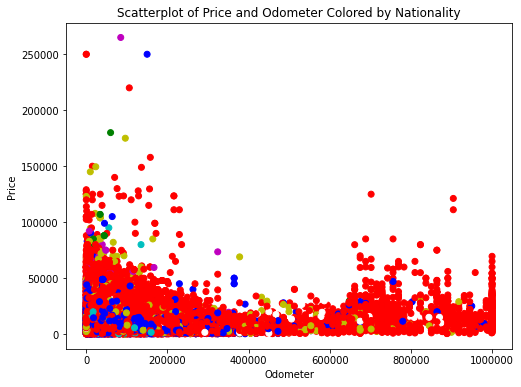

In [370]:
plt.figure(figsize = (8, 6))
plt.ticklabel_format(style = "plain")
plt.scatter(cars_linear_data["odometer"], cars_linear_data["price"], c = categorical["nationality_colors"])
plt.xlabel("Odometer")
plt.ylabel("Price")
plt.title("Scatterplot of Price and Odometer Colored by Nationality")

Text(0.5, 1.0, 'Scatterplot of Price and Year Colored by Nationality')

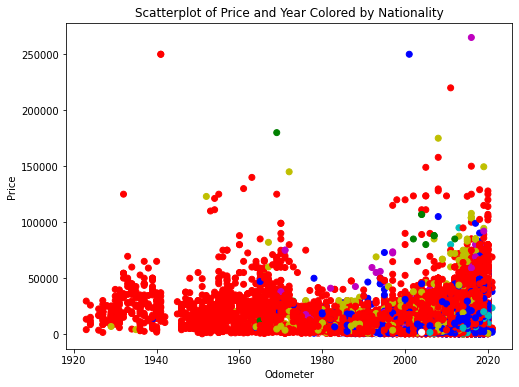

In [372]:
plt.figure(figsize = (8, 6))
plt.ticklabel_format(style = "plain")
plt.scatter(cars_linear_data["year"], cars_linear_data["price"], c = categorical["nationality_colors"])
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Scatterplot of Price and Year Colored by Nationality")

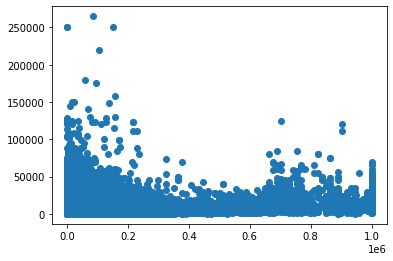

In [374]:
#import statsmodels.api as sm
#import numpy as np
#import matplotlib.pyplot as plt

#X = np.random.rand(100)
#Y = X + np.random.rand(100)*0.1
#cars_linear_data["odometer"], cars_linear_data["price"]
results = sm.OLS(cars_linear_data["price"],sm.add_constant(cars_linear_data["odometer"])).fit()

#print results.summary()

plt.scatter(cars_linear_data["odometer"], cars_linear_data["price"])

X_plot = np.linspace(0,1,100)
plt.plot(X_plot, X_plot*results.params[0] + results.params[1])

plt.show()